In [1]:
from numpy import zeros
from numpy import ones

from numpy.random import randn
from numpy.random import randint

from tensorflow.keras.datasets.cifar10 import load_data

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

import matplotlib.pyplot as plt

In [2]:
# discriminator 

def disc(in_shape=(32, 32, 3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
# generator 

def gen(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3, 3), activation = 'tanh', padding = 'same'))
    return model

In [4]:
# combined generator and discriminator for updating the generator

def dg(gen, disc):
    # make weights in the discriminator not trainable
    disc.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(gen)
    # add the discriminator
    model.add(disc)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [5]:
# load and prepare cifar10 training images

def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [6]:
# select real samples

def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [7]:
# generate points in latent space as input for the generator

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [8]:
# use the generator to generate n fake examples, with class labels

def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [9]:
# create and save a plot of generated images

def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
        
    pyplot.show()

In [10]:
# create and save a plot of generated images

def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])

	plt.show()

In [13]:
# evaluate the discriminator, plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 1/390, d1=0.691, d2=0.695 g=0.692
>1, 2/390, d1=0.639, d2=0.697 g=0.690
>1, 3/390, d1=0.571, d2=0.701 g=0.686
>1, 4/390, d1=0.499, d2=0.713 g=0.675
>1, 5/390, d1=0.406, d2=0.744 g=0.651
>1, 6/390, d1=0.281, d2=0.811 g=0.610
>1, 7/390, d1=0.193, d2=0.899 g=0.583
>1, 8/390, d1=0.151, d2=0.941 g=0.597
>1, 9/390, d1=0.162, d2=0.894 g=0.661
>1, 10/390, d1=0.146, d2=0.764 g=0.754
>1, 11/390, d1=0.209, d2=0.666 g=0.846
>1, 12/390, d1=0.235, d2=0.621 g=0.897
>1, 13/390, d1=0.199, d2=0.615 g=0.907
>1, 14/390, d1=0.199, d2=0.600 g=0.875
>1, 15/390, d1=0.193, d2=0.614 g=0.848
>1, 16/390, d1=0.143, d2=0.602 g=0.831
>1, 17/390, d1=0.147, d2=0.618 g=0.810
>1, 18/390, d1=0.079, d2=0.624 g=0.799
>1, 19/390, d1=0.085, d2=0.634 g=0.790
>1, 20/390, d1=0.168, d2=0.667 g=0.783
>1, 21/390, d1=0.099, d2=0.735 g=0.775
>1, 22/390, d1=0.107, d2=1.048 g=0.708
>1, 23/390, d1=0.055, d2=1.219 g=0.844
>1, 24/390, d1=0.083, d2=0.630 g=1.298
>1, 25/390, d1=0.334, d2=0.530 g=1.013
>1, 26/390, d1=0.214, d2=0.698 g=0

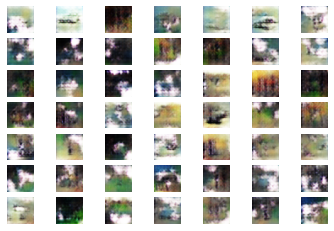

>11, 1/390, d1=0.658, d2=0.565 g=1.047
>11, 2/390, d1=0.691, d2=0.576 g=1.150
>11, 3/390, d1=0.620, d2=0.510 g=1.138
>11, 4/390, d1=0.571, d2=0.529 g=1.227
>11, 5/390, d1=0.691, d2=0.572 g=1.104
>11, 6/390, d1=0.605, d2=0.589 g=1.144
>11, 7/390, d1=0.611, d2=0.598 g=1.114
>11, 8/390, d1=0.670, d2=0.533 g=1.133
>11, 9/390, d1=0.664, d2=0.557 g=1.094
>11, 10/390, d1=0.604, d2=0.562 g=1.101
>11, 11/390, d1=0.605, d2=0.522 g=1.088
>11, 12/390, d1=0.534, d2=0.606 g=1.102
>11, 13/390, d1=0.608, d2=0.572 g=1.129
>11, 14/390, d1=0.498, d2=0.677 g=1.062
>11, 15/390, d1=0.504, d2=0.622 g=1.089
>11, 16/390, d1=0.548, d2=0.590 g=0.982
>11, 17/390, d1=0.543, d2=0.686 g=1.027
>11, 18/390, d1=0.657, d2=0.706 g=1.023
>11, 19/390, d1=0.706, d2=0.591 g=0.994
>11, 20/390, d1=0.565, d2=0.657 g=0.966
>11, 21/390, d1=0.709, d2=0.660 g=0.989
>11, 22/390, d1=0.563, d2=0.601 g=1.030
>11, 23/390, d1=0.662, d2=0.576 g=1.029
>11, 24/390, d1=0.678, d2=0.629 g=1.010
>11, 25/390, d1=0.649, d2=0.640 g=1.050
>11, 26/3

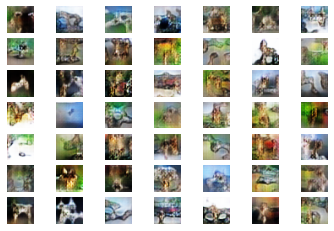

>21, 1/390, d1=0.653, d2=0.666 g=0.841
>21, 2/390, d1=0.710, d2=0.620 g=0.840
>21, 3/390, d1=0.621, d2=0.657 g=0.870
>21, 4/390, d1=0.687, d2=0.617 g=0.850
>21, 5/390, d1=0.719, d2=0.639 g=0.819
>21, 6/390, d1=0.719, d2=0.629 g=0.842
>21, 7/390, d1=0.701, d2=0.620 g=0.866
>21, 8/390, d1=0.632, d2=0.626 g=0.819
>21, 9/390, d1=0.631, d2=0.670 g=0.839
>21, 10/390, d1=0.602, d2=0.686 g=0.847
>21, 11/390, d1=0.665, d2=0.665 g=0.822
>21, 12/390, d1=0.616, d2=0.608 g=0.855
>21, 13/390, d1=0.680, d2=0.631 g=0.849
>21, 14/390, d1=0.659, d2=0.667 g=0.855
>21, 15/390, d1=0.706, d2=0.676 g=0.857
>21, 16/390, d1=0.654, d2=0.716 g=0.803
>21, 17/390, d1=0.648, d2=0.663 g=0.833
>21, 18/390, d1=0.723, d2=0.637 g=0.868
>21, 19/390, d1=0.719, d2=0.632 g=0.818
>21, 20/390, d1=0.649, d2=0.638 g=0.901
>21, 21/390, d1=0.672, d2=0.661 g=0.894
>21, 22/390, d1=0.677, d2=0.633 g=0.853
>21, 23/390, d1=0.615, d2=0.640 g=0.851
>21, 24/390, d1=0.576, d2=0.627 g=0.833
>21, 25/390, d1=0.608, d2=0.640 g=0.830
>21, 26/3

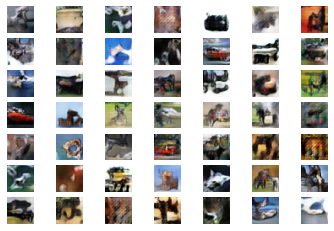

>31, 1/390, d1=0.639, d2=0.628 g=0.898
>31, 2/390, d1=0.652, d2=0.589 g=0.894
>31, 3/390, d1=0.772, d2=0.615 g=0.847
>31, 4/390, d1=0.680, d2=0.663 g=0.807
>31, 5/390, d1=0.690, d2=0.665 g=0.815
>31, 6/390, d1=0.739, d2=0.730 g=0.859
>31, 7/390, d1=0.679, d2=0.571 g=0.885
>31, 8/390, d1=0.676, d2=0.603 g=0.906
>31, 9/390, d1=0.648, d2=0.666 g=0.827
>31, 10/390, d1=0.699, d2=0.721 g=0.785
>31, 11/390, d1=0.636, d2=0.717 g=0.827
>31, 12/390, d1=0.680, d2=0.647 g=0.823
>31, 13/390, d1=0.662, d2=0.691 g=0.826
>31, 14/390, d1=0.695, d2=0.633 g=0.877
>31, 15/390, d1=0.684, d2=0.591 g=0.906
>31, 16/390, d1=0.679, d2=0.626 g=0.879
>31, 17/390, d1=0.747, d2=0.623 g=0.883
>31, 18/390, d1=0.656, d2=0.598 g=0.893
>31, 19/390, d1=0.730, d2=0.655 g=0.869
>31, 20/390, d1=0.687, d2=0.593 g=0.861
>31, 21/390, d1=0.690, d2=0.643 g=0.848
>31, 22/390, d1=0.686, d2=0.646 g=0.854
>31, 23/390, d1=0.685, d2=0.663 g=0.874
>31, 24/390, d1=0.633, d2=0.622 g=0.842
>31, 25/390, d1=0.657, d2=0.591 g=0.850
>31, 26/3

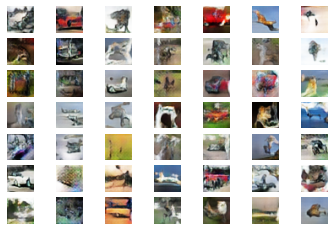

>41, 1/390, d1=0.657, d2=0.673 g=0.845
>41, 2/390, d1=0.703, d2=0.640 g=0.795
>41, 3/390, d1=0.635, d2=0.709 g=0.813
>41, 4/390, d1=0.672, d2=0.689 g=0.815
>41, 5/390, d1=0.681, d2=0.648 g=0.838
>41, 6/390, d1=0.633, d2=0.630 g=0.821
>41, 7/390, d1=0.637, d2=0.657 g=0.815
>41, 8/390, d1=0.627, d2=0.656 g=0.807
>41, 9/390, d1=0.601, d2=0.716 g=0.781
>41, 10/390, d1=0.627, d2=0.692 g=0.757
>41, 11/390, d1=0.647, d2=0.714 g=0.850
>41, 12/390, d1=0.657, d2=0.669 g=0.863
>41, 13/390, d1=0.691, d2=0.652 g=0.862
>41, 14/390, d1=0.684, d2=0.636 g=0.868
>41, 15/390, d1=0.702, d2=0.638 g=0.865
>41, 16/390, d1=0.672, d2=0.607 g=0.845
>41, 17/390, d1=0.660, d2=0.659 g=0.819
>41, 18/390, d1=0.690, d2=0.713 g=0.882
>41, 19/390, d1=0.725, d2=0.593 g=0.867
>41, 20/390, d1=0.682, d2=0.681 g=0.882
>41, 21/390, d1=0.693, d2=0.636 g=0.845
>41, 22/390, d1=0.664, d2=0.622 g=0.824
>41, 23/390, d1=0.695, d2=0.647 g=0.791
>41, 24/390, d1=0.683, d2=0.622 g=0.810
>41, 25/390, d1=0.613, d2=0.665 g=0.803
>41, 26/3

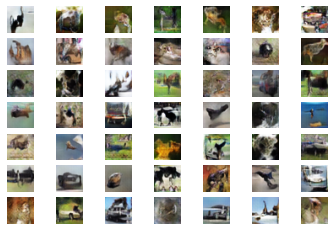

In [14]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
   
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = disc()
# create the generator
g_model = gen(latent_dim)
# create the gan
gan_model = dg(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)